In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [39]:
xls = pd.ExcelFile('20180509_Business_Analyst_Case.xlsx')
df = pd.read_excel(xls, 'Data')

In [40]:
df = df.drop(np.arange(7)).reset_index()
df.columns = df.iloc[0]
df = df[1:]
df = df.reset_index().drop(columns = [7, 'index'])
df.columns = df.columns.str.lower().str.replace(' ', '_')

### Customer Orders Data
- **"Customer":** Unique customers who started buying our products in Jan or February 2018
- **"Date Shipped":** Date when orders were fulfilled.  Note that some customers made multiple orders (repeat purchases) while other customers did not.
- **"Product ID":** Unique SKU representing which product was ordered
- **"Brand":**  The customers were buyers of one of 3 brands.  They only purchased from 1 of the 3.
- **"Channel":** How we acquired these customers

### Insight Questions - What keeps customers coming back?
<ol>
    <li> Which brand(s) are stronger and which are weaker at driving repeat purchases? </li>
    <li>Does the marketing channel used to acquire customers make a difference?  </li>
    <li>Are there specific products which are associated with repeat purchases? </li>
    <li>Any other insights that you think would be relevant? </li>
<li>What would be your recommendations around Brand, Product, Marketing to improve repeat purchases?</li>
</ol>

In [43]:
df.head()

,customer,date_shipped,product_id,brand,channel
0,8711264,2018-01-03 00:00:00,677,White Whale,Partner
1,8711416,2018-01-03 00:00:00,677,White Whale,Direct
2,8711424,2018-01-03 00:00:00,494,Black Dog,Direct
3,8712968,2018-01-03 00:00:00,677,White Whale,Direct
4,8714688,2018-01-03 00:00:00,677,White Whale,Direct


Which brands are stronger/weaker amongst repeat purchases?
- Get dataframe of repeat purchases only
- Determine most successful brand
    - Aggregate level
         - Is channel related?
         - Is there a particular time that weights a certain brand?
    - Unique repeat customers? (make new dataset)

In [45]:
repeat_df = df[df.duplicated(subset = 'customer') == True]

In [48]:
#brand proportion amongst repeat customers
repeat_prop = repeat_df.groupby(['brand']).count()['customer'] / repeat_df.shape[0]

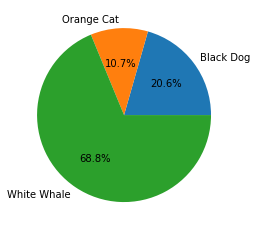

In [70]:
fraction = list(repeat_prop)
label = list(repeat_prop.index)
plt.pie(fraction, labels = label, autopct = '%1.1f%%');

From this aggregation of repeat customers, it would seem that White Whale is the most popular choice of Dog Food at nearly 70% of purchases from repeat customers, while Orange Cat and Black Dog occupying the . However, it is uncertain if this could be driven by a particular buyer or by a particular time. For instance, White Whale could be an enormous purchase done by a single individual or supplier which would greatly inflate it's popularity.

### Unique Repeat Customers

In [80]:
#number of repeats from dataset
repeat_df.groupby(['customer']).count()['brand'].describe()

count    3334.000000
mean        1.939412
std         0.756562
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         7.000000
Name: brand, dtype: float64

It would seem that on average the usual number of repeats is around 2, with the maximum of 7. Although it would seem that there are no outrageous outliers in terms of repeat buyers, it may still be useful to check if strictly unique buyers are considered. Below, two different pie charts will be created

### Repeat Customers Graphed Over Time